In [1]:
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import preamble
from src.constants import COLOR_MAPS, PATH_VOCAB_EMBEDDED, EMBEDDING_MODEL, PATH_MIGRATION_SPEECHES_EMBEDDED
from src.dim_reduction import display_axis_semantics, closest_words_for_pc, get_extreme_examples, get_aggregated_embeddings_for_each_year

In [2]:
df = pd.read_parquet(PATH_MIGRATION_SPEECHES_EMBEDDED)
print(f"#Samples: {len(df)}")

#Samples: 9705


In [3]:
vocab_df = pd.read_parquet(PATH_VOCAB_EMBEDDED)

# Partial least squares regression

Identify component in our embeddings which explain our target variable (party affiliation)

In [4]:
aggregated = get_aggregated_embeddings_for_each_year(df, EMBEDDING_MODEL, 'block')

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split

X = np.stack(df[EMBEDDING_MODEL])


lb = LabelEncoder()
y = lb.fit_transform(df["block"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

print(f"#Classes {len(lb.classes_)}")

y = np.eye(len(lb.classes_))[y_train]  # create one-hot encodding to use PLS for classification PLS-DA


pls = PLSRegression(n_components=2)
pls.fit(X_train, y)

reduced = pls.transform(X)

print(f"PLS r-squared {pls.score(X_test, np.eye(len(lb.classes_))[y_test]):.3f}")


#Classes 6
PLS r-squared 0.105


## Plotting Results

In [6]:
def plot_aggregated_yearly_data(aggregated: pd.DataFrame, reduced_embeddings: np.array, target_var: str, color_map: dict, ax):
  ax.set_title("Two Dimensional Projection of Political Groups")

  grt = np.abs(reduced_embeddings).max() * 1.1

  ax.set_xlim(-grt, grt)
  ax.set_ylim(-grt, grt)

  scale = grt * 2


  for party in aggregated[target_var].unique():
      party_mask = aggregated[target_var] == party
      years = aggregated[party_mask]['year']
      party_embeddings = reduced_embeddings[party_mask]
      
      ax.scatter(party_embeddings[:, 0], party_embeddings[:, 1], marker='o', color=color_map[party], label=party)
      for i, year in enumerate(years):
        ax.text(party_embeddings[i,0] - scale * 0.01, party_embeddings[i,1]+ scale * 0.015, f"{year}",
                  fontsize=8, bbox=dict(boxstyle="round", color=color_map[party], alpha=0.7), 
                  color='white',
                  )

  ax.axhline(0, linestyle="--")
  ax.axvline(0, linestyle="--")
  ax.grid()
  ax.legend(loc="upper left")
  return ax

In [7]:
def plot_pca_axis_development(axis: int, aggregated: pd.DataFrame,  target_var: str, reduced_embeddings: np.array, 
                              axis_labels: tuple[list[str]], color_map: dict, ax: plt.Axes,
                              top_k: int = 3):

    ax.set_title(f"Development of parties over the years accross reduced-axis {axis}")

    for party in aggregated[target_var].unique():
        party_mask = aggregated[target_var] == party
        years = aggregated[party_mask]['year']
        party_embeddings = reduced_embeddings[party_mask]
        ax.plot(years,  party_embeddings[:, axis], marker='o', color=color_map[party])

    
    max_y_lim = max(abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))

    ax.set_ylim((-max_y_lim, max_y_lim))  
    ax.axhline(0, linestyle="--")

    ax_label_neg = ', '.join(map(lambda x: x[0], axis_labels[0][:top_k]))
    ax_label_pos = ', '.join(map(lambda x: x[0], axis_labels[1][:top_k]))

    props = dict(boxstyle='round', facecolor="grey", alpha=0.5)

    # label for negative axis: 
    ax.text(2014, -0.8 * max_y_lim , f"{ax_label_neg}", horizontalalignment="left", bbox=props)
    # label for positive axis: 
    ax.text(2014, 0.8 * max_y_lim, f"{ax_label_pos}", horizontalalignment="left", bbox=props)
    ax.grid()
    # ax.legend(loc="lower left")


In [8]:
def display_results(model, axis: tuple[int], aggregated: pd.DataFrame, vocab_df: pd.DataFrame,
                     reduced_embeddings: np.stack, target_var: str, color_map: dict) -> None:
    
    fig = plt.figure(layout="constrained", figsize=(18, 8))

    gs0 = fig.add_gridspec(1, 2)

    gs1 = gs0[1].subgridspec(2, 1)

    ax1 = fig.add_subplot(gs0[0])
    ax2 = fig.add_subplot(gs1[0])
    ax3 = fig.add_subplot(gs1[1], sharex=ax2)

    axis_labels_0 = closest_words_for_pc(axis[0], model, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))
    axis_labels_1  = closest_words_for_pc(axis[1], model, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))

    display_axis_semantics([(axis_labels_0), 
                            (axis_labels_1)])

    plot_aggregated_yearly_data(aggregated, reduced_embeddings, target_var, color_map, ax1)
    plot_pca_axis_development(0, aggregated, target_var, reduced_embeddings, axis_labels_0, color_map, ax2)
    plot_pca_axis_development(1, aggregated, target_var, reduced_embeddings, axis_labels_1, color_map, ax3)


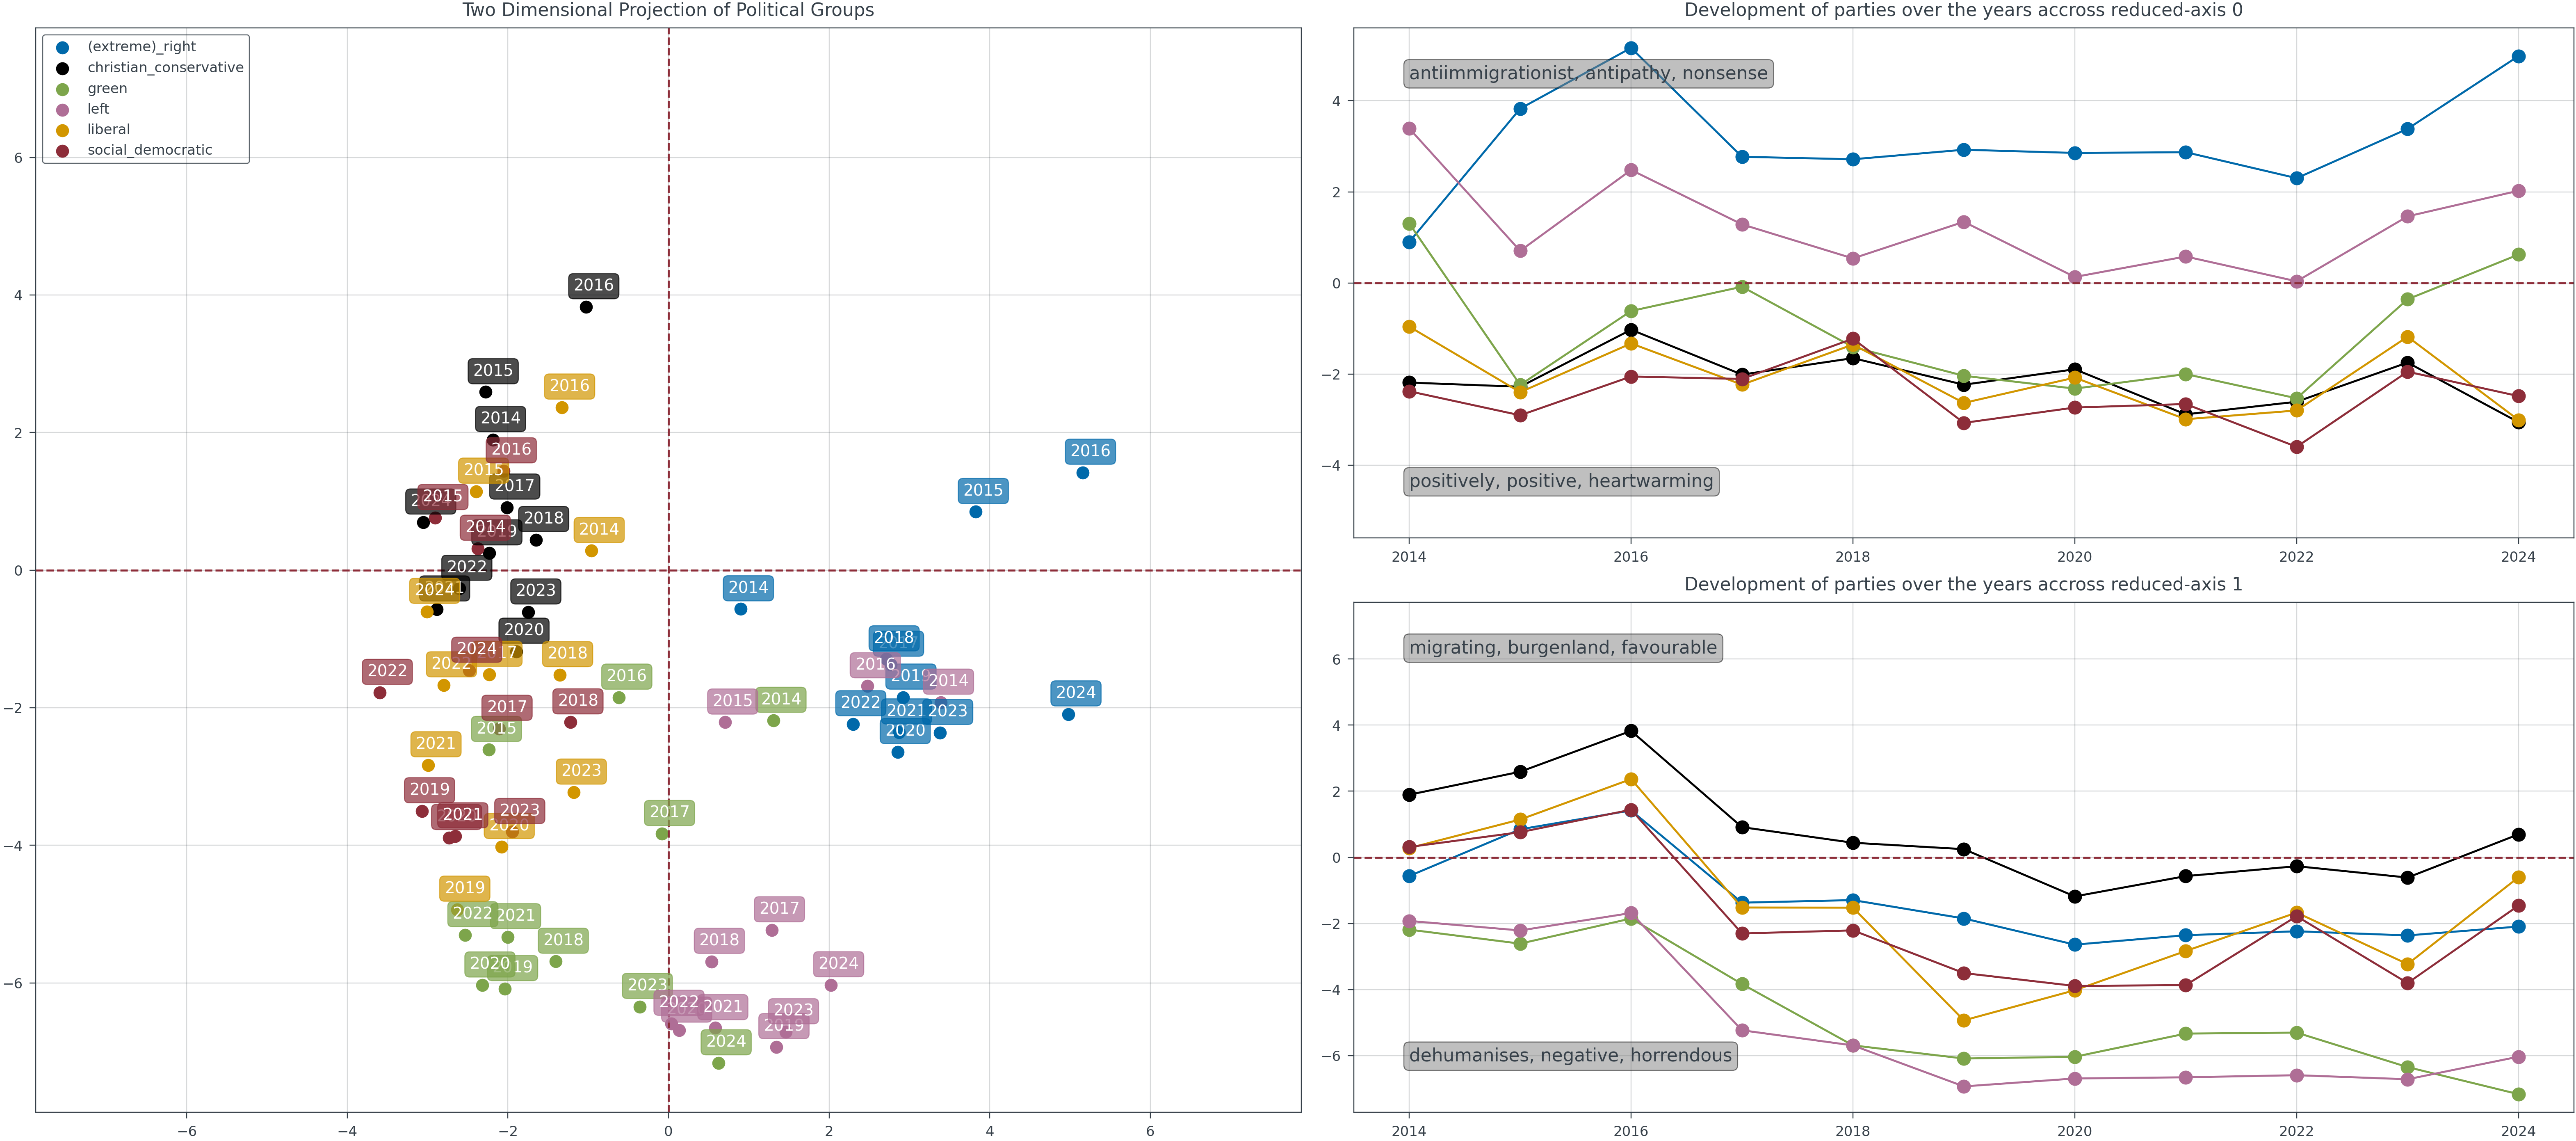

In [9]:
display_results(pls, [0, 1], aggregated, vocab_df, 
                pls.transform(np.stack(aggregated[EMBEDDING_MODEL])), "block", COLOR_MAPS['block'])

In [10]:
reduced = pls.transform(np.stack(df[EMBEDDING_MODEL]))
normalized = reduced 
#/ np.linalg.vector_norm(reduced, ord=2, axis=1, keepdims=True)

In [11]:
def get_top_k_extreme_examples(df: pd.DataFrame, embeddings: np.array, top_k=10):
    sorted_0 = embeddings[:, 0].argsort()
    sorted_1 = embeddings[:, 1].argsort()
    return df.iloc[sorted_0[:top_k]], df.iloc[sorted_0[-top_k:]], df.iloc[sorted_1[:top_k]], df.iloc[sorted_1[-top_k:]]

In [12]:
reduced[:, 0].argsort()

array([ 730, 8254, 1235, ..., 4797, 7537, 6912], shape=(9705,))

In [13]:
df.iloc[6912]['translatedText']

'I voted against this report, because it gives an inappropriate role to migrants.'

In [14]:
import textwrap
left_mask = df['block'] == '(extreme)_right'
neg_0, pos_0, neg_1, pos_1 = get_top_k_extreme_examples(df[left_mask], normalized[left_mask])

In [15]:
for row in pos_1.iloc:
    print(textwrap.fill(row['translatedText']))
    print("=" * 200)

I supported the report on the proposal for a regulation of the
European Parliament and of the Council amending Council Regulation  No
768/2005 establishing the Community Fisheries Control Agency because,
alongside the European Border and Coast Guard and the European
Maritime Agency safety, this is the third new agency in the package
proposed by the Commission to strengthen the management of the Union's
external green and sea borders. As I have repeatedly stated, I am of
the opinion that the protection of the EU's external borders should be
a priority in the fight against illegal immigration.
There are two components in the Draft Amending Budget (Amendment
Budget) No. 1/2016. The first part concerns the development of a new
instrument for the provision of emergency aid within the EU. The
second part contains a transfer of funds to the European Counter-
Terrorism Centre. In my opinion, dealing with the immigration crisis
requires a comprehensive strategy, not piecemeal work, as the Europ

In [16]:
print(textwrap.fill(pos_0.iloc[0]['translatedText']))

Vote against the report which contains no criticism of the failed
industrial policies developed by the Commission; few and few steps
have been taken against the wild relocation of some multinationals.


In [17]:
X = np.stack(df[EMBEDDING_MODEL])


lb = LabelEncoder()

# create one-hot encodding to use PLS for classification PLS-DA

y_block = lb.fit_transform(df["block"])
y_block = np.eye(len(lb.classes_))[y_block]
y_year = lb.fit_transform(df["year"])
y_year = np.eye(len(lb.classes_))[y_year] 

y = np.concat([y_block, y_year], axis=1)


pls = PLSRegression(n_components=2)
pls.fit(X, y)

reduced = pls.transform(X)

# PLS + Clustering
With PLS and our vocab embeddings we can try to find out which 

In [18]:
len(df['party'].unique())

8

First thing we want to do is find num of clusters who can separate our data the most. For this we can use silhouette coefficient
nearest_other_cluster_dist - intra_cluster_dist / max_of_the_two

In [29]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from tqdm import tqdm


silhouette_scores = {}

for num_clusters in tqdm(range(len(df['party'].unique()), len(df['party'].unique()) * len(df["year"].unique()) + 1)):

    kmeans = KMeans(n_clusters=num_clusters)
    predicted_clusters = kmeans.fit_predict(X)

    silhouette_scores[num_clusters] = silhouette_score(X, predicted_clusters)


100%|██████████| 81/81 [03:05<00:00,  2.30s/it]


In [31]:
max(silhouette_scores.items(), key=lambda item: item[1])

(72, 0.03850667551159859)

Near 0 meaning clusters are overlaping, not as easily separable as we'd have liked

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score

# X = np.stack(df[EMBEDDING_MODEL])
# results = {}

# for num_clusters in tqdm(range(len(df['party'].unique()), len(df['party'].unique()) * len(df["year"].unique()) + 1)):

#     kmeans = KMeans(n_clusters=num_clusters)
#     predicted_clusters = kmeans.fit_predict(X)

#     pls = PLSRegression(n_components=2)

#     y = np.eye(num_clusters)[predicted_clusters]

#     X_train, X_test, y_train, y_test = train_test_split(X, y)

#     pls.fit(X_train, y_train)

#     y_pred = pls.predict(X_test).argmax(axis=1)
#     y_test = y_test.argmax(axis=1)

    
#     results[num_clusters] = f1_score(y_test, y_pred, average="micro")  # classes are getting bigger as n_clusters increases so we want to make it n_class agnostic by measuring micro labels

100%|██████████| 81/81 [01:49<00:00,  1.35s/it]


In [38]:
kmeans = KMeans(n_clusters=72)
predicted_clusters = kmeans.fit_predict(X)

In [39]:
df.groupby(predicted_clusters)['block'].value_counts()

    block                 
0   (extreme)_right           61
    christian_conservative     4
    social_democratic          2
    green                      1
1   christian_conservative    73
                              ..
71  christian_conservative    38
    social_democratic         36
    green                     16
    left                      13
    liberal                   12
Name: count, Length: 417, dtype: int64

In [41]:
pls = PLSRegression(n_components=2)
y = np.eye(num_clusters)[predicted_clusters]
pls.fit(X, y)

,n_components,2
,scale,True
,max_iter,500
,tol,1e-06
,copy,True


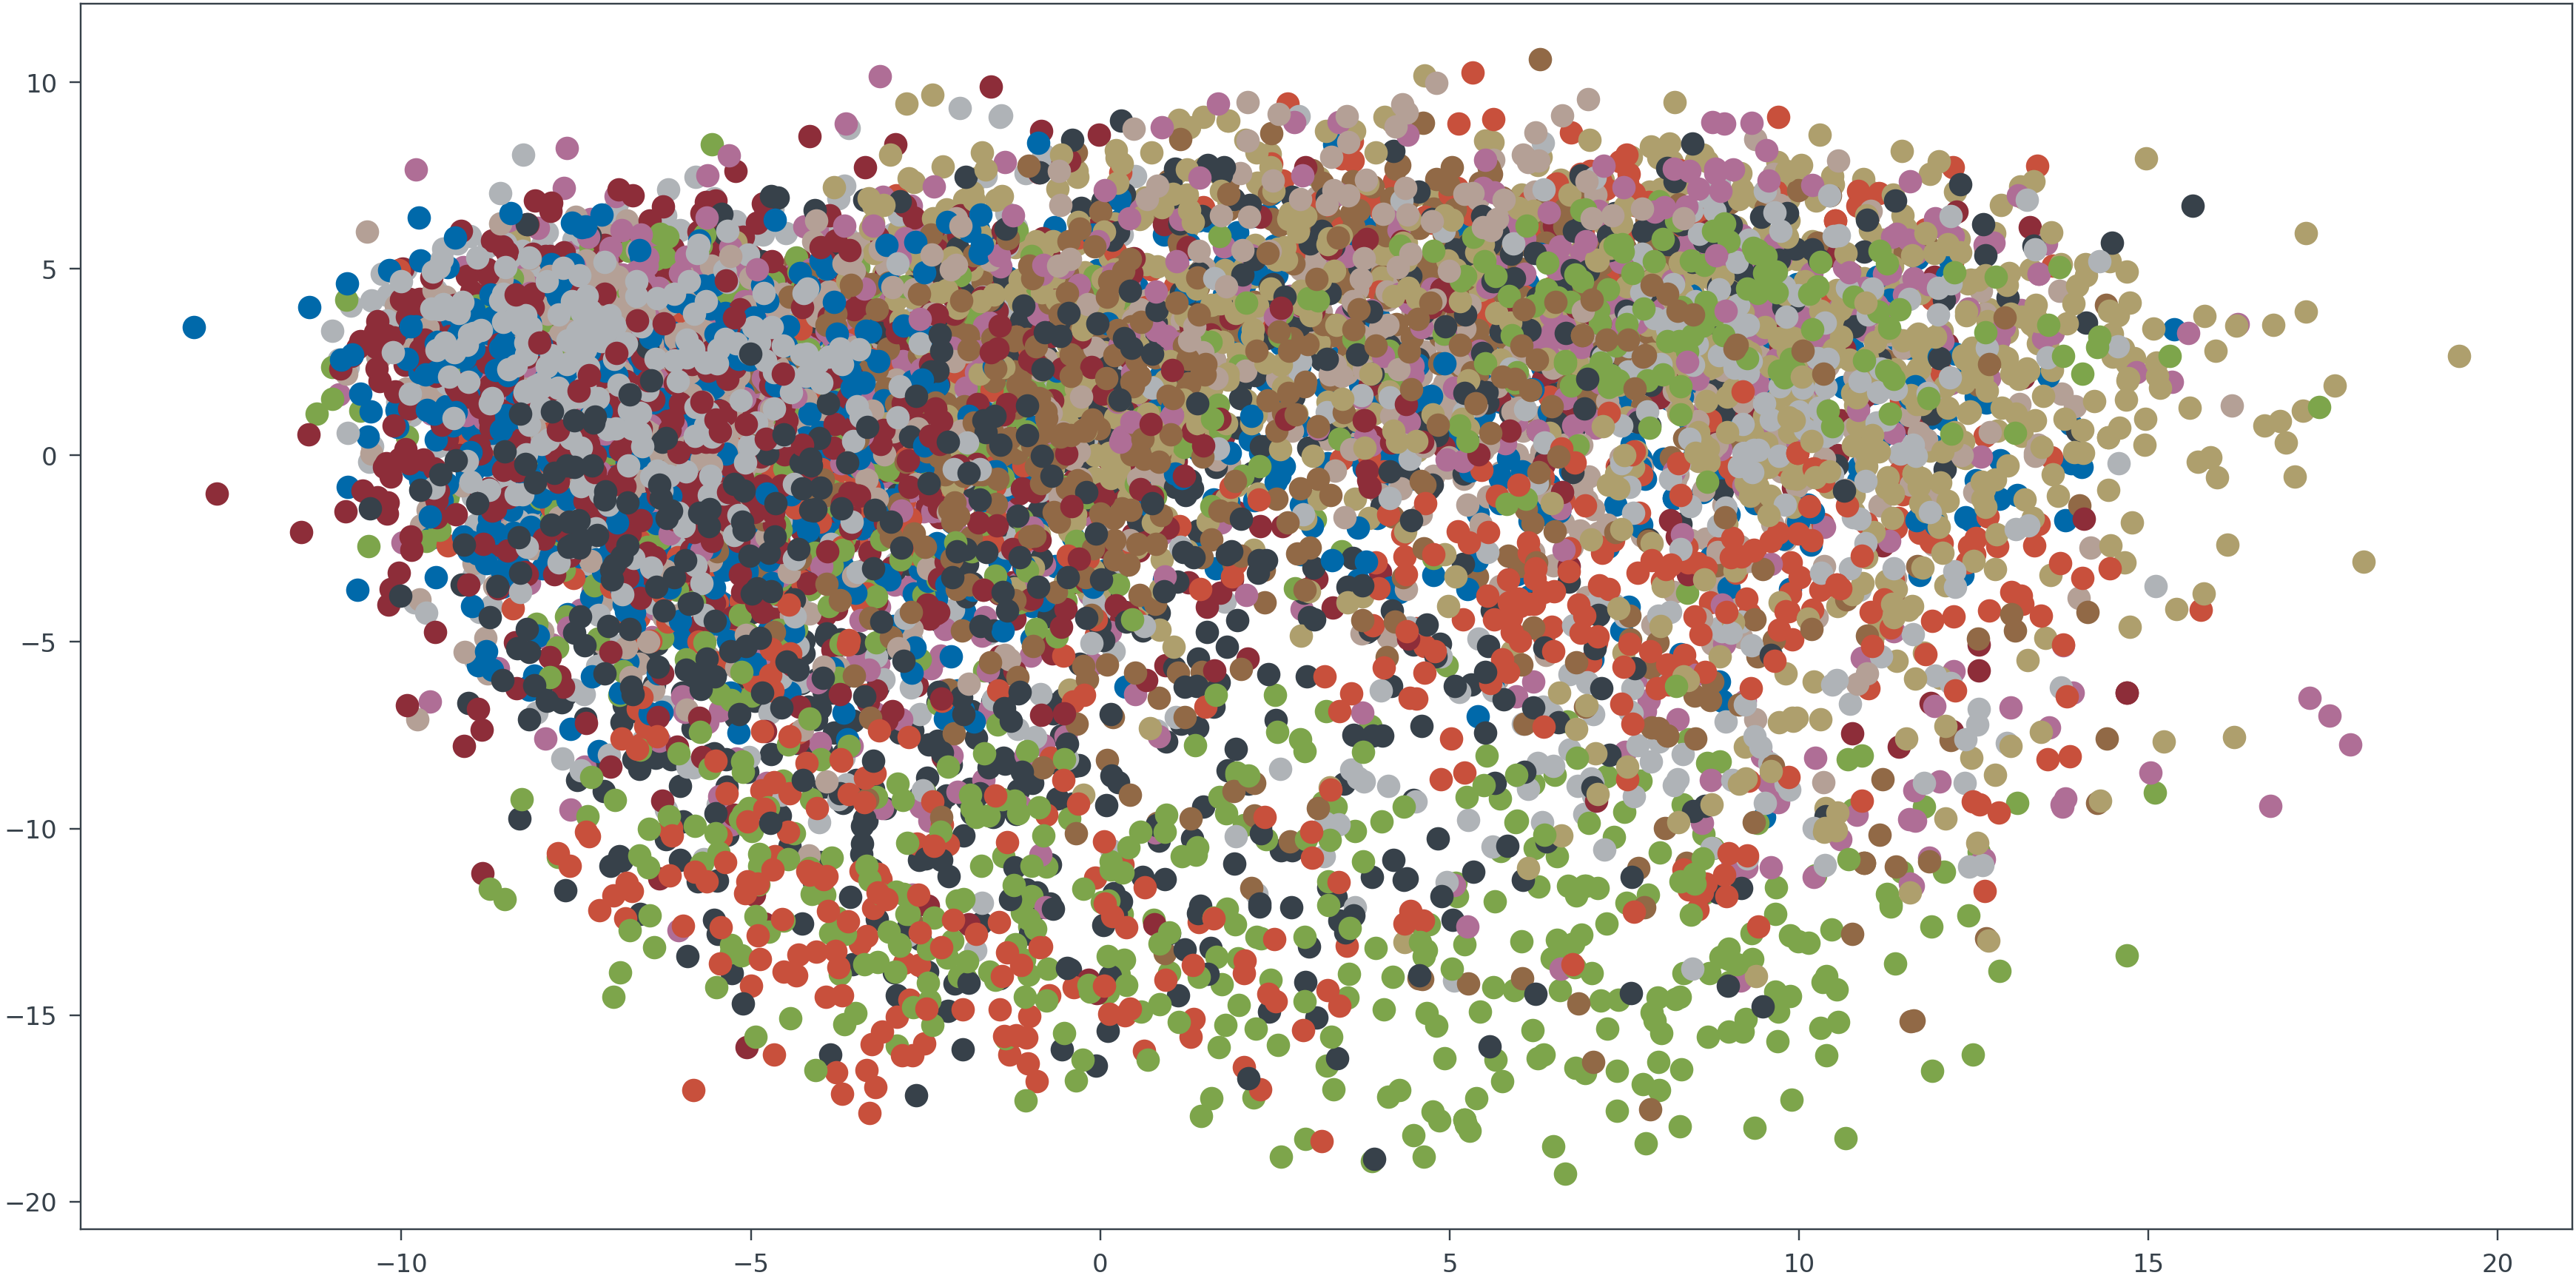

In [42]:
reduced = pls.transform(X)

fig, ax = plt.subplots(figsize=(10, 5))

for cluster_id in range(72):
    mask = predicted_clusters == cluster_id
    ax.scatter(reduced[mask, 0], reduced[mask, 1])

In [43]:
axis_labels_0 = closest_words_for_pc(0, pls, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))
axis_labels_1  = closest_words_for_pc(1, pls, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))

In [44]:
display_axis_semantics([axis_labels_0, axis_labels_1])